In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'
data_root = 'plates'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 1694.37it/s]


In [3]:
!ls train

cleaned dirty


In [4]:
import torch
import torchvision
import matplotlib.pyplot as plt
import time
import copy
from torchvision import transforms, models
from PIL import Image

def apply_transform(img, _type="train", angle=0):
    if _type == "train":
        train_transforms = transforms.Compose([
            transforms.Lambda(lambda x: transforms.functional.affine(x, angle,
                                                                     translate=(0, 0), scale=1, 
                                                                     shear = False)),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        return train_transforms(img)
    elif _type == "val":
        val_transforms = transforms.Compose([
            transforms.Lambda(lambda x: transforms.functional.affine(x, angle,
                                                                     translate=(0, 0), scale=1, 
                                                                     shear = False)),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        return val_transforms(img)

In [5]:
train_dataset = []
val_dataset = []
step = 90
for name in os.listdir(train_dir + '/' + class_names[0]):
    if not name.endswith('jpg'):
        continue
    for angle in range(0, 360, step):
        img = Image.open(train_dir + '/' + class_names[0] + '/' + name)
        train_dataset.append((apply_transform(img, "train", angle), 0))
for name in os.listdir(train_dir + '/' + class_names[1]):
    if not name.endswith('jpg'):
        continue
    for angle in range(0, 360, step):
        img = Image.open(train_dir + '/' + class_names[1] + '/' + name)
        train_dataset.append((apply_transform(img, "train", angle), 1))
for name in os.listdir(val_dir + '/' + class_names[0]):
    if not name.endswith('jpg'):
        continue
    for angle in range(0, 360, step):
        img = Image.open(val_dir + '/' + class_names[0] + '/' + name)
        val_dataset.append((apply_transform(img, "val", angle), 0))
for name in os.listdir(val_dir + '/' + class_names[0]):
    if not name.endswith('jpg'):
        continue
    for angle in range(0, 360, step):
        img = Image.open(val_dir + '/' + class_names[1] + '/' + name)
        val_dataset.append((apply_transform(img, "val", angle), 1))

In [6]:
batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [7]:
len(train_dataloader), len(train_dataset)

(34, 272)

In [8]:
len(val_dataloader), len(val_dataset)

(6, 48)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


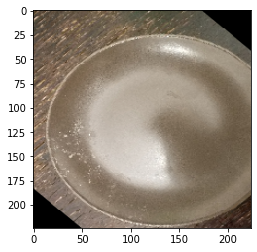

In [9]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

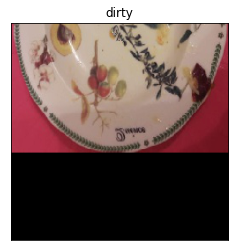

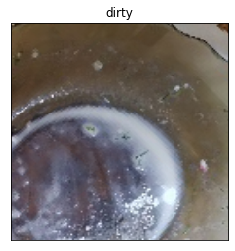

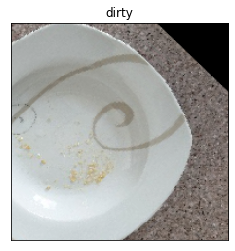

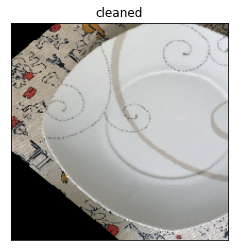

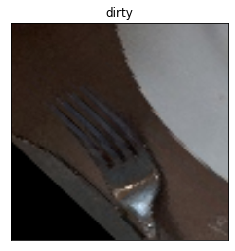

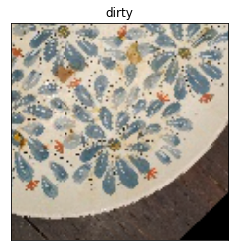

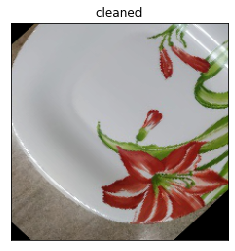

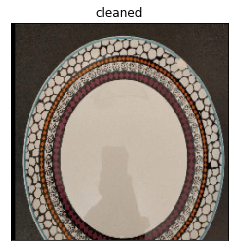

In [10]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.show() 
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [11]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [12]:
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [13]:
train_model(model, loss, optimizer, scheduler, num_epochs=100)

Epoch 0/99:


/Users/anastasiabogatenkova/miniconda3/envs/sphere/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 34/34 [00:17<00:00,  1.95it/s]

train Loss: 0.6620 Acc: 0.5809



100%|██████████| 6/6 [00:02<00:00,  2.22it/s]

val Loss: 0.7338 Acc: 0.5417
Epoch 1/99:



100%|██████████| 34/34 [00:17<00:00,  1.93it/s]

train Loss: 0.5292 Acc: 0.7390



100%|██████████| 6/6 [00:02<00:00,  2.16it/s]

val Loss: 0.6710 Acc: 0.5625
Epoch 2/99:



100%|██████████| 34/34 [00:17<00:00,  1.91it/s]

train Loss: 0.4131 Acc: 0.8088



100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

val Loss: 0.6359 Acc: 0.6250
Epoch 3/99:



100%|██████████| 34/34 [00:17<00:00,  1.94it/s]

train Loss: 0.4341 Acc: 0.7941



100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

val Loss: 0.5715 Acc: 0.6458
Epoch 4/99:



100%|██████████| 34/34 [00:17<00:00,  1.97it/s]

train Loss: 0.3629 Acc: 0.8493



100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

val Loss: 0.5987 Acc: 0.6250
Epoch 5/99:



100%|██████████| 34/34 [00:17<00:00,  1.98it/s]

train Loss: 0.3928 Acc: 0.8272



100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

val Loss: 0.7061 Acc: 0.6250
Epoch 6/99:



100%|██████████| 34/34 [00:17<00:00,  2.00it/s]

train Loss: 0.3392 Acc: 0.8640



100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

val Loss: 0.6356 Acc: 0.6667
Epoch 7/99:



100%|██████████| 34/34 [00:16<00:00,  2.00it/s]

train Loss: 0.3630 Acc: 0.8272



100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

val Loss: 0.6165 Acc: 0.6042
Epoch 8/99:



100%|██████████| 34/34 [00:17<00:00,  1.99it/s]

train Loss: 0.3553 Acc: 0.8529



100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

val Loss: 0.6684 Acc: 0.6250
Epoch 9/99:



100%|██████████| 34/34 [00:17<00:00,  1.91it/s]

train Loss: 0.3055 Acc: 0.8934



100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

val Loss: 0.5821 Acc: 0.6875
Epoch 10/99:



100%|██████████| 34/34 [00:16<00:00,  2.00it/s]

train Loss: 0.3161 Acc: 0.8860



100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

val Loss: 0.6064 Acc: 0.6250
Epoch 11/99:



100%|██████████| 34/34 [00:17<00:00,  1.98it/s]

train Loss: 0.3191 Acc: 0.8713



100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

val Loss: 0.5808 Acc: 0.6667
Epoch 12/99:



100%|██████████| 34/34 [00:17<00:00,  1.97it/s]

train Loss: 0.2835 Acc: 0.9044



100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

val Loss: 0.5439 Acc: 0.6875
Epoch 13/99:



100%|██████████| 34/34 [00:17<00:00,  1.99it/s]

train Loss: 0.2999 Acc: 0.8860



100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

val Loss: 0.5964 Acc: 0.6458
Epoch 14/99:



100%|██████████| 34/34 [00:17<00:00,  1.98it/s]

train Loss: 0.2973 Acc: 0.9154



100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

val Loss: 0.6038 Acc: 0.6250
Epoch 15/99:



100%|██████████| 34/34 [00:16<00:00,  2.00it/s]

train Loss: 0.3102 Acc: 0.8750



100%|██████████| 6/6 [00:02<00:00,  2.15it/s]

val Loss: 0.5727 Acc: 0.6875
Epoch 16/99:



100%|██████████| 34/34 [00:17<00:00,  1.94it/s]

train Loss: 0.3038 Acc: 0.9044



100%|██████████| 6/6 [00:02<00:00,  2.33it/s]

val Loss: 0.5582 Acc: 0.6875
Epoch 17/99:



100%|██████████| 34/34 [00:17<00:00,  1.95it/s]

train Loss: 0.2923 Acc: 0.9118



100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

val Loss: 0.5726 Acc: 0.6667
Epoch 18/99:



100%|██████████| 34/34 [00:16<00:00,  2.00it/s]

train Loss: 0.3077 Acc: 0.8713



100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

val Loss: 0.5698 Acc: 0.6667
Epoch 19/99:



100%|██████████| 34/34 [00:17<00:00,  1.98it/s]

train Loss: 0.2991 Acc: 0.8824



100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

val Loss: 0.5711 Acc: 0.6667
Epoch 20/99:



100%|██████████| 34/34 [00:17<00:00,  1.98it/s]

train Loss: 0.3150 Acc: 0.8971



100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

val Loss: 0.5549 Acc: 0.6875
Epoch 21/99:



100%|██████████| 34/34 [00:17<00:00,  1.97it/s]

train Loss: 0.3237 Acc: 0.8713



100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

val Loss: 0.5518 Acc: 0.6667
Epoch 22/99:



100%|██████████| 34/34 [00:17<00:00,  1.96it/s]

train Loss: 0.3033 Acc: 0.8897



100%|██████████| 6/6 [00:02<00:00,  2.20it/s]

val Loss: 0.5521 Acc: 0.6667
Epoch 23/99:



100%|██████████| 34/34 [00:17<00:00,  1.96it/s]

train Loss: 0.3061 Acc: 0.9081



100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

val Loss: 0.5943 Acc: 0.6667
Epoch 24/99:



100%|██████████| 34/34 [00:17<00:00,  1.96it/s]

train Loss: 0.3205 Acc: 0.8860



100%|██████████| 6/6 [00:02<00:00,  2.17it/s]

val Loss: 0.6069 Acc: 0.6458
Epoch 25/99:



100%|██████████| 34/34 [00:17<00:00,  1.91it/s]

train Loss: 0.3168 Acc: 0.8713



100%|██████████| 6/6 [00:02<00:00,  2.17it/s]

val Loss: 0.5605 Acc: 0.6875
Epoch 26/99:



100%|██████████| 34/34 [00:17<00:00,  1.92it/s]

train Loss: 0.3283 Acc: 0.8529



100%|██████████| 6/6 [00:02<00:00,  2.16it/s]

val Loss: 0.5717 Acc: 0.6875
Epoch 27/99:



100%|██████████| 34/34 [00:17<00:00,  1.94it/s]

train Loss: 0.3353 Acc: 0.8529



100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

val Loss: 0.6122 Acc: 0.6250
Epoch 28/99:



100%|██████████| 34/34 [00:16<00:00,  2.03it/s]

train Loss: 0.3072 Acc: 0.8897



100%|██████████| 6/6 [00:02<00:00,  2.35it/s]

val Loss: 0.5635 Acc: 0.6667
Epoch 29/99:



100%|██████████| 34/34 [00:16<00:00,  2.04it/s]

train Loss: 0.3024 Acc: 0.8971



100%|██████████| 6/6 [00:02<00:00,  2.37it/s]

val Loss: 0.5972 Acc: 0.6667
Epoch 30/99:



100%|██████████| 34/34 [00:16<00:00,  2.03it/s]

train Loss: 0.3156 Acc: 0.8897



100%|██████████| 6/6 [00:02<00:00,  2.37it/s]

val Loss: 0.5836 Acc: 0.6667
Epoch 31/99:



100%|██████████| 34/34 [00:16<00:00,  2.01it/s]

train Loss: 0.3208 Acc: 0.8750



100%|██████████| 6/6 [00:02<00:00,  2.37it/s]

val Loss: 0.5624 Acc: 0.6667
Epoch 32/99:



100%|██████████| 34/34 [00:16<00:00,  2.01it/s]

train Loss: 0.2984 Acc: 0.9154



100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

val Loss: 0.5647 Acc: 0.6667
Epoch 33/99:



100%|██████████| 34/34 [00:16<00:00,  2.01it/s]

train Loss: 0.2939 Acc: 0.9044



100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

val Loss: 0.5808 Acc: 0.6667
Epoch 34/99:



100%|██████████| 34/34 [00:16<00:00,  2.01it/s]

train Loss: 0.2904 Acc: 0.8971



100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

val Loss: 0.5511 Acc: 0.6875
Epoch 35/99:



100%|██████████| 34/34 [00:16<00:00,  2.01it/s]

train Loss: 0.3370 Acc: 0.8860



100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

val Loss: 0.5871 Acc: 0.6667
Epoch 36/99:



100%|██████████| 34/34 [00:16<00:00,  2.00it/s]

train Loss: 0.3171 Acc: 0.8640



100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

val Loss: 0.5798 Acc: 0.6667
Epoch 37/99:



100%|██████████| 34/34 [00:17<00:00,  2.00it/s]

train Loss: 0.3181 Acc: 0.8603



100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

val Loss: 0.5705 Acc: 0.6667
Epoch 38/99:



100%|██████████| 34/34 [00:17<00:00,  1.98it/s]

train Loss: 0.3432 Acc: 0.8456



100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

val Loss: 0.5728 Acc: 0.6667
Epoch 39/99:



100%|██████████| 34/34 [00:16<00:00,  2.00it/s]

train Loss: 0.3123 Acc: 0.8787



100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

val Loss: 0.5843 Acc: 0.6667
Epoch 40/99:



100%|██████████| 34/34 [00:16<00:00,  2.01it/s]

train Loss: 0.3411 Acc: 0.8529



100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

val Loss: 0.5765 Acc: 0.6667
Epoch 41/99:



100%|██████████| 34/34 [00:16<00:00,  2.02it/s]

train Loss: 0.3608 Acc: 0.8603



100%|██████████| 6/6 [00:02<00:00,  2.38it/s]

val Loss: 0.5769 Acc: 0.6667
Epoch 42/99:



100%|██████████| 34/34 [00:16<00:00,  2.04it/s]

train Loss: 0.2889 Acc: 0.8897



100%|██████████| 6/6 [00:02<00:00,  2.37it/s]

val Loss: 0.5884 Acc: 0.6458
Epoch 43/99:



100%|██████████| 34/34 [00:16<00:00,  2.03it/s]

train Loss: 0.2888 Acc: 0.9044



100%|██████████| 6/6 [00:02<00:00,  2.37it/s]

val Loss: 0.5906 Acc: 0.6667
Epoch 44/99:



100%|██████████| 34/34 [00:16<00:00,  2.07it/s]

train Loss: 0.3053 Acc: 0.8824



100%|██████████| 6/6 [00:02<00:00,  2.41it/s]

val Loss: 0.5834 Acc: 0.6667
Epoch 45/99:



100%|██████████| 34/34 [00:16<00:00,  2.04it/s]

train Loss: 0.3327 Acc: 0.8566



100%|██████████| 6/6 [00:02<00:00,  2.33it/s]

val Loss: 0.5602 Acc: 0.6875
Epoch 46/99:



100%|██████████| 34/34 [00:16<00:00,  2.03it/s]

train Loss: 0.3234 Acc: 0.8676



100%|██████████| 6/6 [00:02<00:00,  2.36it/s]

val Loss: 0.5928 Acc: 0.6667
Epoch 47/99:



100%|██████████| 34/34 [00:16<00:00,  2.04it/s]

train Loss: 0.3116 Acc: 0.8824



100%|██████████| 6/6 [00:02<00:00,  2.35it/s]

val Loss: 0.5480 Acc: 0.7083
Epoch 48/99:



100%|██████████| 34/34 [00:16<00:00,  2.04it/s]

train Loss: 0.3287 Acc: 0.8824



100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

val Loss: 0.5617 Acc: 0.6875
Epoch 49/99:



100%|██████████| 34/34 [00:16<00:00,  2.05it/s]

train Loss: 0.3163 Acc: 0.8676



100%|██████████| 6/6 [00:02<00:00,  2.42it/s]

val Loss: 0.5518 Acc: 0.6875
Epoch 50/99:



100%|██████████| 34/34 [00:16<00:00,  2.08it/s]

train Loss: 0.3044 Acc: 0.8713



100%|██████████| 6/6 [00:02<00:00,  2.43it/s]

val Loss: 0.5733 Acc: 0.6458
Epoch 51/99:



100%|██████████| 34/34 [00:16<00:00,  2.06it/s]

train Loss: 0.3377 Acc: 0.8309



100%|██████████| 6/6 [00:02<00:00,  2.42it/s]

val Loss: 0.5596 Acc: 0.6667
Epoch 52/99:



100%|██████████| 34/34 [00:16<00:00,  2.08it/s]

train Loss: 0.3229 Acc: 0.8750



100%|██████████| 6/6 [00:02<00:00,  2.40it/s]

val Loss: 0.5864 Acc: 0.6667
Epoch 53/99:



100%|██████████| 34/34 [00:16<00:00,  2.07it/s]

train Loss: 0.3140 Acc: 0.8971



100%|██████████| 6/6 [00:02<00:00,  2.41it/s]

val Loss: 0.5604 Acc: 0.6667
Epoch 54/99:



100%|██████████| 34/34 [00:16<00:00,  2.04it/s]

train Loss: 0.2533 Acc: 0.9228



100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

val Loss: 0.5834 Acc: 0.6667
Epoch 55/99:



100%|██████████| 34/34 [00:16<00:00,  2.04it/s]

train Loss: 0.2982 Acc: 0.8860



100%|██████████| 6/6 [00:02<00:00,  2.35it/s]

val Loss: 0.5865 Acc: 0.6875
Epoch 56/99:



100%|██████████| 34/34 [00:16<00:00,  2.04it/s]

train Loss: 0.3301 Acc: 0.8824



100%|██████████| 6/6 [00:02<00:00,  2.33it/s]

val Loss: 0.5708 Acc: 0.6875
Epoch 57/99:



100%|██████████| 34/34 [00:16<00:00,  2.04it/s]

train Loss: 0.2792 Acc: 0.9044



100%|██████████| 6/6 [00:02<00:00,  2.36it/s]

val Loss: 0.5918 Acc: 0.6250
Epoch 58/99:



100%|██████████| 34/34 [00:16<00:00,  2.05it/s]

train Loss: 0.3208 Acc: 0.8750



100%|██████████| 6/6 [00:02<00:00,  2.37it/s]

val Loss: 0.5726 Acc: 0.6667
Epoch 59/99:



100%|██████████| 34/34 [00:16<00:00,  2.05it/s]

train Loss: 0.3010 Acc: 0.8971



100%|██████████| 6/6 [00:02<00:00,  2.37it/s]

val Loss: 0.5599 Acc: 0.7292
Epoch 60/99:



100%|██████████| 34/34 [00:16<00:00,  2.05it/s]

train Loss: 0.3286 Acc: 0.8676



100%|██████████| 6/6 [00:02<00:00,  2.37it/s]

val Loss: 0.6029 Acc: 0.6458
Epoch 61/99:



100%|██████████| 34/34 [00:16<00:00,  2.05it/s]

train Loss: 0.3474 Acc: 0.8419



100%|██████████| 6/6 [00:02<00:00,  2.37it/s]

val Loss: 0.5542 Acc: 0.6875
Epoch 62/99:



100%|██████████| 34/34 [00:16<00:00,  2.05it/s]

train Loss: 0.3065 Acc: 0.8824



100%|██████████| 6/6 [00:02<00:00,  2.40it/s]

val Loss: 0.5651 Acc: 0.6458
Epoch 63/99:



100%|██████████| 34/34 [00:16<00:00,  2.07it/s]

train Loss: 0.3270 Acc: 0.8493



100%|██████████| 6/6 [00:02<00:00,  2.43it/s]

val Loss: 0.5906 Acc: 0.6458
Epoch 64/99:



100%|██████████| 34/34 [00:16<00:00,  2.09it/s]

train Loss: 0.3255 Acc: 0.8676



100%|██████████| 6/6 [00:02<00:00,  2.43it/s]

val Loss: 0.5976 Acc: 0.6458
Epoch 65/99:



100%|██████████| 34/34 [00:16<00:00,  2.09it/s]

train Loss: 0.3152 Acc: 0.8860



100%|██████████| 6/6 [00:02<00:00,  2.44it/s]

val Loss: 0.5576 Acc: 0.6875
Epoch 66/99:



100%|██████████| 34/34 [00:16<00:00,  2.08it/s]

train Loss: 0.3356 Acc: 0.8750



100%|██████████| 6/6 [00:02<00:00,  2.37it/s]

val Loss: 0.5613 Acc: 0.6667
Epoch 67/99:



100%|██████████| 34/34 [00:16<00:00,  2.05it/s]

train Loss: 0.2883 Acc: 0.9044



100%|██████████| 6/6 [00:02<00:00,  2.36it/s]

val Loss: 0.5720 Acc: 0.6667
Epoch 68/99:



100%|██████████| 34/34 [00:16<00:00,  2.05it/s]

train Loss: 0.3169 Acc: 0.8934



100%|██████████| 6/6 [00:02<00:00,  2.36it/s]

val Loss: 0.6028 Acc: 0.6667
Epoch 69/99:



100%|██████████| 34/34 [00:16<00:00,  2.04it/s]

train Loss: 0.2903 Acc: 0.9044



100%|██████████| 6/6 [00:02<00:00,  2.35it/s]

val Loss: 0.5689 Acc: 0.6667
Epoch 70/99:



100%|██████████| 34/34 [00:16<00:00,  2.04it/s]

train Loss: 0.3107 Acc: 0.8750



100%|██████████| 6/6 [00:02<00:00,  2.36it/s]

val Loss: 0.5754 Acc: 0.6667
Epoch 71/99:



100%|██████████| 34/34 [00:16<00:00,  2.05it/s]

train Loss: 0.3008 Acc: 0.8934



100%|██████████| 6/6 [00:02<00:00,  2.37it/s]

val Loss: 0.6002 Acc: 0.6250
Epoch 72/99:



100%|██████████| 34/34 [00:16<00:00,  2.05it/s]

train Loss: 0.2970 Acc: 0.9007



100%|██████████| 6/6 [00:02<00:00,  2.37it/s]

val Loss: 0.5999 Acc: 0.6458
Epoch 73/99:



100%|██████████| 34/34 [00:16<00:00,  2.05it/s]

train Loss: 0.3384 Acc: 0.8566



100%|██████████| 6/6 [00:02<00:00,  2.37it/s]

val Loss: 0.5684 Acc: 0.6667
Epoch 74/99:



100%|██████████| 34/34 [00:16<00:00,  2.04it/s]

train Loss: 0.3020 Acc: 0.8934



100%|██████████| 6/6 [00:02<00:00,  2.38it/s]

val Loss: 0.5668 Acc: 0.6667
Epoch 75/99:



100%|██████████| 34/34 [00:16<00:00,  2.06it/s]

train Loss: 0.2879 Acc: 0.9007



100%|██████████| 6/6 [00:02<00:00,  2.41it/s]

val Loss: 0.5684 Acc: 0.6667
Epoch 76/99:



100%|██████████| 34/34 [00:16<00:00,  2.08it/s]

train Loss: 0.2835 Acc: 0.9118



100%|██████████| 6/6 [00:02<00:00,  2.41it/s]

val Loss: 0.5528 Acc: 0.6667
Epoch 77/99:



100%|██████████| 34/34 [00:16<00:00,  2.08it/s]

train Loss: 0.3174 Acc: 0.8713



100%|██████████| 6/6 [00:02<00:00,  2.42it/s]

val Loss: 0.5886 Acc: 0.6458
Epoch 78/99:



100%|██████████| 34/34 [00:16<00:00,  2.08it/s]

train Loss: 0.3284 Acc: 0.8713



100%|██████████| 6/6 [00:02<00:00,  2.42it/s]

val Loss: 0.5718 Acc: 0.6667
Epoch 79/99:



100%|██████████| 34/34 [00:16<00:00,  2.09it/s]

train Loss: 0.3105 Acc: 0.8824



100%|██████████| 6/6 [00:02<00:00,  2.42it/s]

val Loss: 0.5457 Acc: 0.6875
Epoch 80/99:



100%|██████████| 34/34 [00:16<00:00,  2.06it/s]

train Loss: 0.3008 Acc: 0.9081



100%|██████████| 6/6 [00:02<00:00,  2.43it/s]

val Loss: 0.6051 Acc: 0.6250
Epoch 81/99:



100%|██████████| 34/34 [00:17<00:00,  1.99it/s]

train Loss: 0.3116 Acc: 0.8824



100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

val Loss: 0.6069 Acc: 0.6458
Epoch 82/99:



100%|██████████| 34/34 [00:16<00:00,  2.02it/s]

train Loss: 0.3287 Acc: 0.8750



100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

val Loss: 0.5681 Acc: 0.6875
Epoch 83/99:



100%|██████████| 34/34 [00:16<00:00,  2.01it/s]

train Loss: 0.3180 Acc: 0.8860



100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

val Loss: 0.5655 Acc: 0.6667
Epoch 84/99:



100%|██████████| 34/34 [00:16<00:00,  2.01it/s]

train Loss: 0.3081 Acc: 0.8934



100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

val Loss: 0.5999 Acc: 0.6458
Epoch 85/99:



100%|██████████| 34/34 [00:16<00:00,  2.01it/s]

train Loss: 0.3236 Acc: 0.8860



100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

val Loss: 0.5691 Acc: 0.6875
Epoch 86/99:



100%|██████████| 34/34 [00:16<00:00,  2.01it/s]

train Loss: 0.3102 Acc: 0.8934



100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

val Loss: 0.5861 Acc: 0.6458
Epoch 87/99:



100%|██████████| 34/34 [00:16<00:00,  2.00it/s]

train Loss: 0.3191 Acc: 0.8640



100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

val Loss: 0.5722 Acc: 0.6875
Epoch 88/99:



100%|██████████| 34/34 [00:17<00:00,  2.00it/s]

train Loss: 0.3224 Acc: 0.8897



100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

val Loss: 0.5508 Acc: 0.6875
Epoch 89/99:



100%|██████████| 34/34 [00:16<00:00,  2.01it/s]

train Loss: 0.3143 Acc: 0.8750



100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

val Loss: 0.5818 Acc: 0.6458
Epoch 90/99:



100%|██████████| 34/34 [00:17<00:00,  1.97it/s]

train Loss: 0.3064 Acc: 0.8676



100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

val Loss: 0.5742 Acc: 0.6458
Epoch 91/99:



100%|██████████| 34/34 [00:16<00:00,  2.01it/s]

train Loss: 0.2955 Acc: 0.8897



100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

val Loss: 0.6116 Acc: 0.6458
Epoch 92/99:



100%|██████████| 34/34 [00:16<00:00,  2.01it/s]

train Loss: 0.3021 Acc: 0.8934



100%|██████████| 6/6 [00:02<00:00,  2.38it/s]

val Loss: 0.5817 Acc: 0.6250
Epoch 93/99:



100%|██████████| 34/34 [00:16<00:00,  2.05it/s]

train Loss: 0.3184 Acc: 0.8676



100%|██████████| 6/6 [00:02<00:00,  2.43it/s]

val Loss: 0.5465 Acc: 0.6667
Epoch 94/99:



100%|██████████| 34/34 [00:16<00:00,  2.03it/s]

train Loss: 0.3132 Acc: 0.8713



100%|██████████| 6/6 [00:02<00:00,  2.33it/s]

val Loss: 0.5909 Acc: 0.6667
Epoch 95/99:



100%|██████████| 34/34 [00:16<00:00,  2.04it/s]

train Loss: 0.3179 Acc: 0.8787



100%|██████████| 6/6 [00:02<00:00,  2.35it/s]

val Loss: 0.5860 Acc: 0.6875
Epoch 96/99:



100%|██████████| 34/34 [00:16<00:00,  2.04it/s]

train Loss: 0.3259 Acc: 0.8824



100%|██████████| 6/6 [00:02<00:00,  2.35it/s]

val Loss: 0.5706 Acc: 0.6875
Epoch 97/99:



100%|██████████| 34/34 [00:16<00:00,  2.03it/s]

train Loss: 0.3150 Acc: 0.9081



100%|██████████| 6/6 [00:02<00:00,  2.35it/s]

val Loss: 0.5779 Acc: 0.6667
Epoch 98/99:



100%|██████████| 34/34 [00:16<00:00,  2.04it/s]

train Loss: 0.2934 Acc: 0.8860



100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

val Loss: 0.6198 Acc: 0.6667
Epoch 99/99:



100%|██████████| 34/34 [00:17<00:00,  1.97it/s]

train Loss: 0.2754 Acc: 0.9081



100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

val Loss: 0.6029 Acc: 0.6250


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [17]:
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('test', test_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [18]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [19]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [00:43<00:00,  2.14it/s]


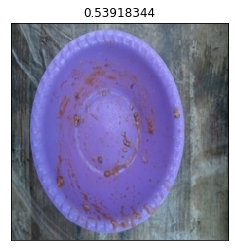

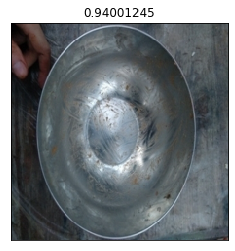

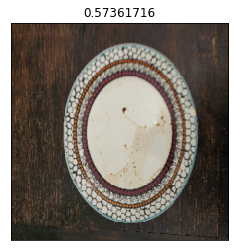

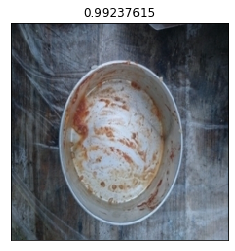

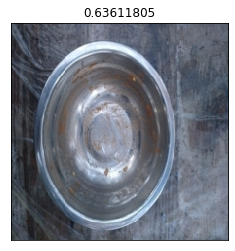

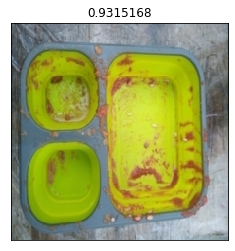

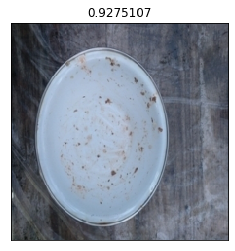

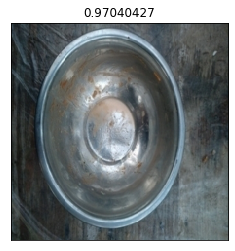

In [20]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [21]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [22]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head()

,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,dirty


In [23]:
submission_df.to_csv('submission_90_step.csv')

In [24]:
!rm -rf train val test